In [93]:
#IMPORT LIABARIES
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os
from sklearn.decomposition import PCA

print(os.getcwd())

c:\Users\MK699GC\OneDrive - EY\Documents\EMAS\Case 6


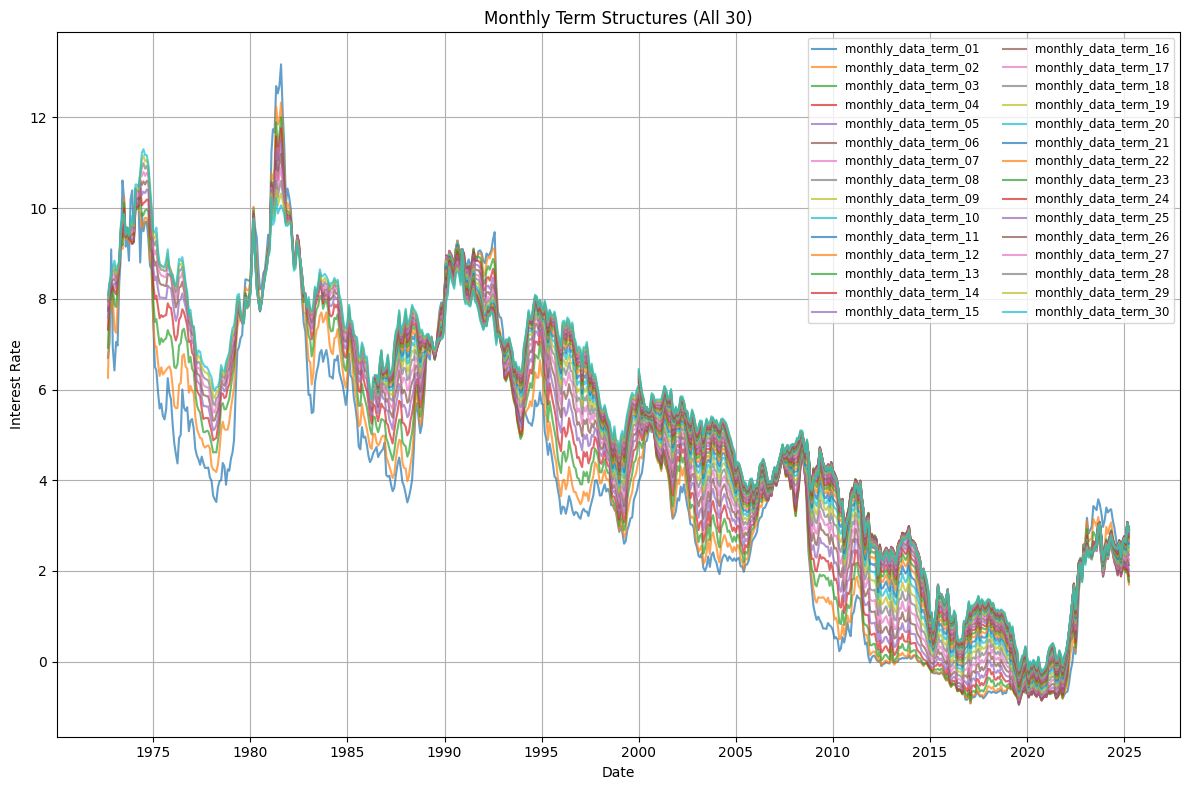

In [94]:
#PLOT MONTHLY TERM STRUCTURE

monthly_df['years'] = pd.to_datetime(monthly_df['years'], errors='coerce')

plt.figure(figsize=(12, 8))

monthly_cols = sorted([col for col in monthly_df.columns if col.startswith('monthly_data_term_')])

for col in monthly_cols:
    plt.plot(monthly_df['years'], monthly_df[col], label=col, alpha=0.7)

plt.title('Monthly Term Structures (All 30)')
plt.xlabel('Date')
plt.ylabel('Interest Rate')

# Stel de x-as formatter en locator in voor datums
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))  # elke 5 jaar een tick
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


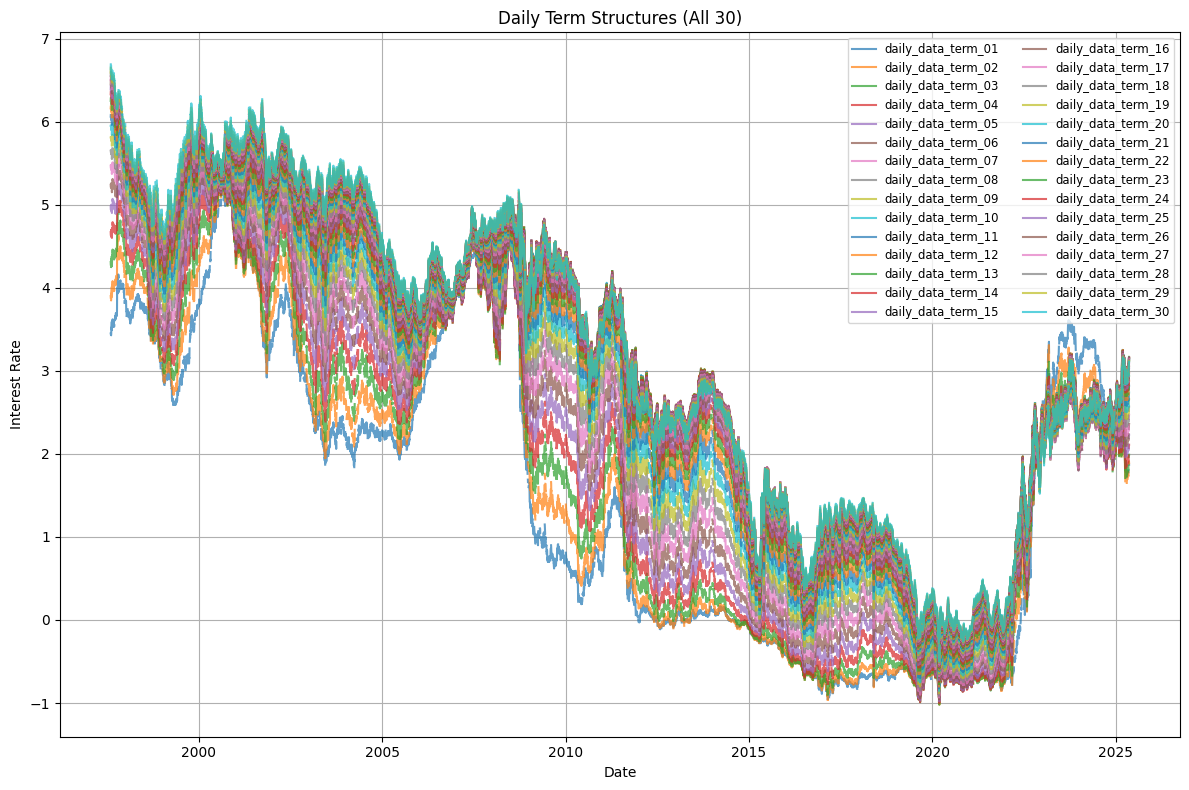

In [95]:
# Zorg dat 'years' datetime is
daily_df['years'] = pd.to_datetime(daily_df['years'], errors='coerce')

plt.figure(figsize=(12, 8))

# Selecteer alle looptijd kolommen die met 'daily_data_term_' beginnen
daily_cols = sorted([col for col in daily_df.columns if col.startswith('daily_data_term_')])

# Plot alle term structures
for col in daily_cols:
    plt.plot(daily_df['years'], daily_df[col], label=col, alpha=0.7)

plt.title('Daily Term Structures (All 30)')
plt.xlabel('Date')
plt.ylabel('Interest Rate')

# X-as instellen met 5-jaars intervallen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
def descriptive_stats(df):
    stats = df.drop(columns=['years']).describe().T
    stats['missing_pct'] = df.drop(columns=['years']).isna().mean() * 100
    
    # Bepaal voor elke kolom de eerste datum waar geen NaN is
    start_years = {}
    for col in stats.index:
        # Zoek de index (rij) van de eerste niet-NAN waarde in die kolom
        first_valid_idx = df[col].first_valid_index()
        if first_valid_idx is not None:
            start_year = df.loc[first_valid_idx, 'years'].year
        else:
            start_year = np.nan
        start_years[col] = start_year
    
    stats['start_year'] = pd.Series(start_years)
    
    # Optioneel, sorteren op start_year
    stats = stats.sort_values('start_year')
    
    return stats[['count', 'mean', '50%', 'std', 'min', 'max', 'missing_pct', 'start_year']]


print("Daily Data Stats:")
print(descriptive_stats(daily_df))

print("\nMonthly Data Stats:")
print(descriptive_stats(monthly_df))

Daily Data Stats:
                      count         mean       50%       std      min  \
daily_data_term_01   7048.0     1.564343     1.805  1.842042    -0.97   
daily_data_term_20   7048.0     3.146633     3.220  1.901452    -0.62   
daily_data_term_19   7048.0     3.121331     3.205  1.898811    -0.64   
daily_data_term_18   7048.0     3.091735     3.190  1.896570    -0.65   
daily_data_term_17   7048.0     3.057348     3.165  1.894763    -0.67   
year                10150.0  2010.975862  2011.000  8.032150  1997.00   
daily_data_term_15   7048.0     2.971840     3.090  1.892460    -0.72   
daily_data_term_14   7048.0     2.919421     3.040  1.892116    -0.74   
daily_data_term_13   7048.0     2.859667     2.980  1.892588    -0.77   
daily_data_term_12   7048.0     2.791820     2.910  1.893829    -0.80   
daily_data_term_16   7048.0     3.017618     3.130  1.893271    -0.69   
daily_data_term_10   7048.0     2.629012     2.760  1.898492    -0.85   
daily_data_term_11   7048.0     2

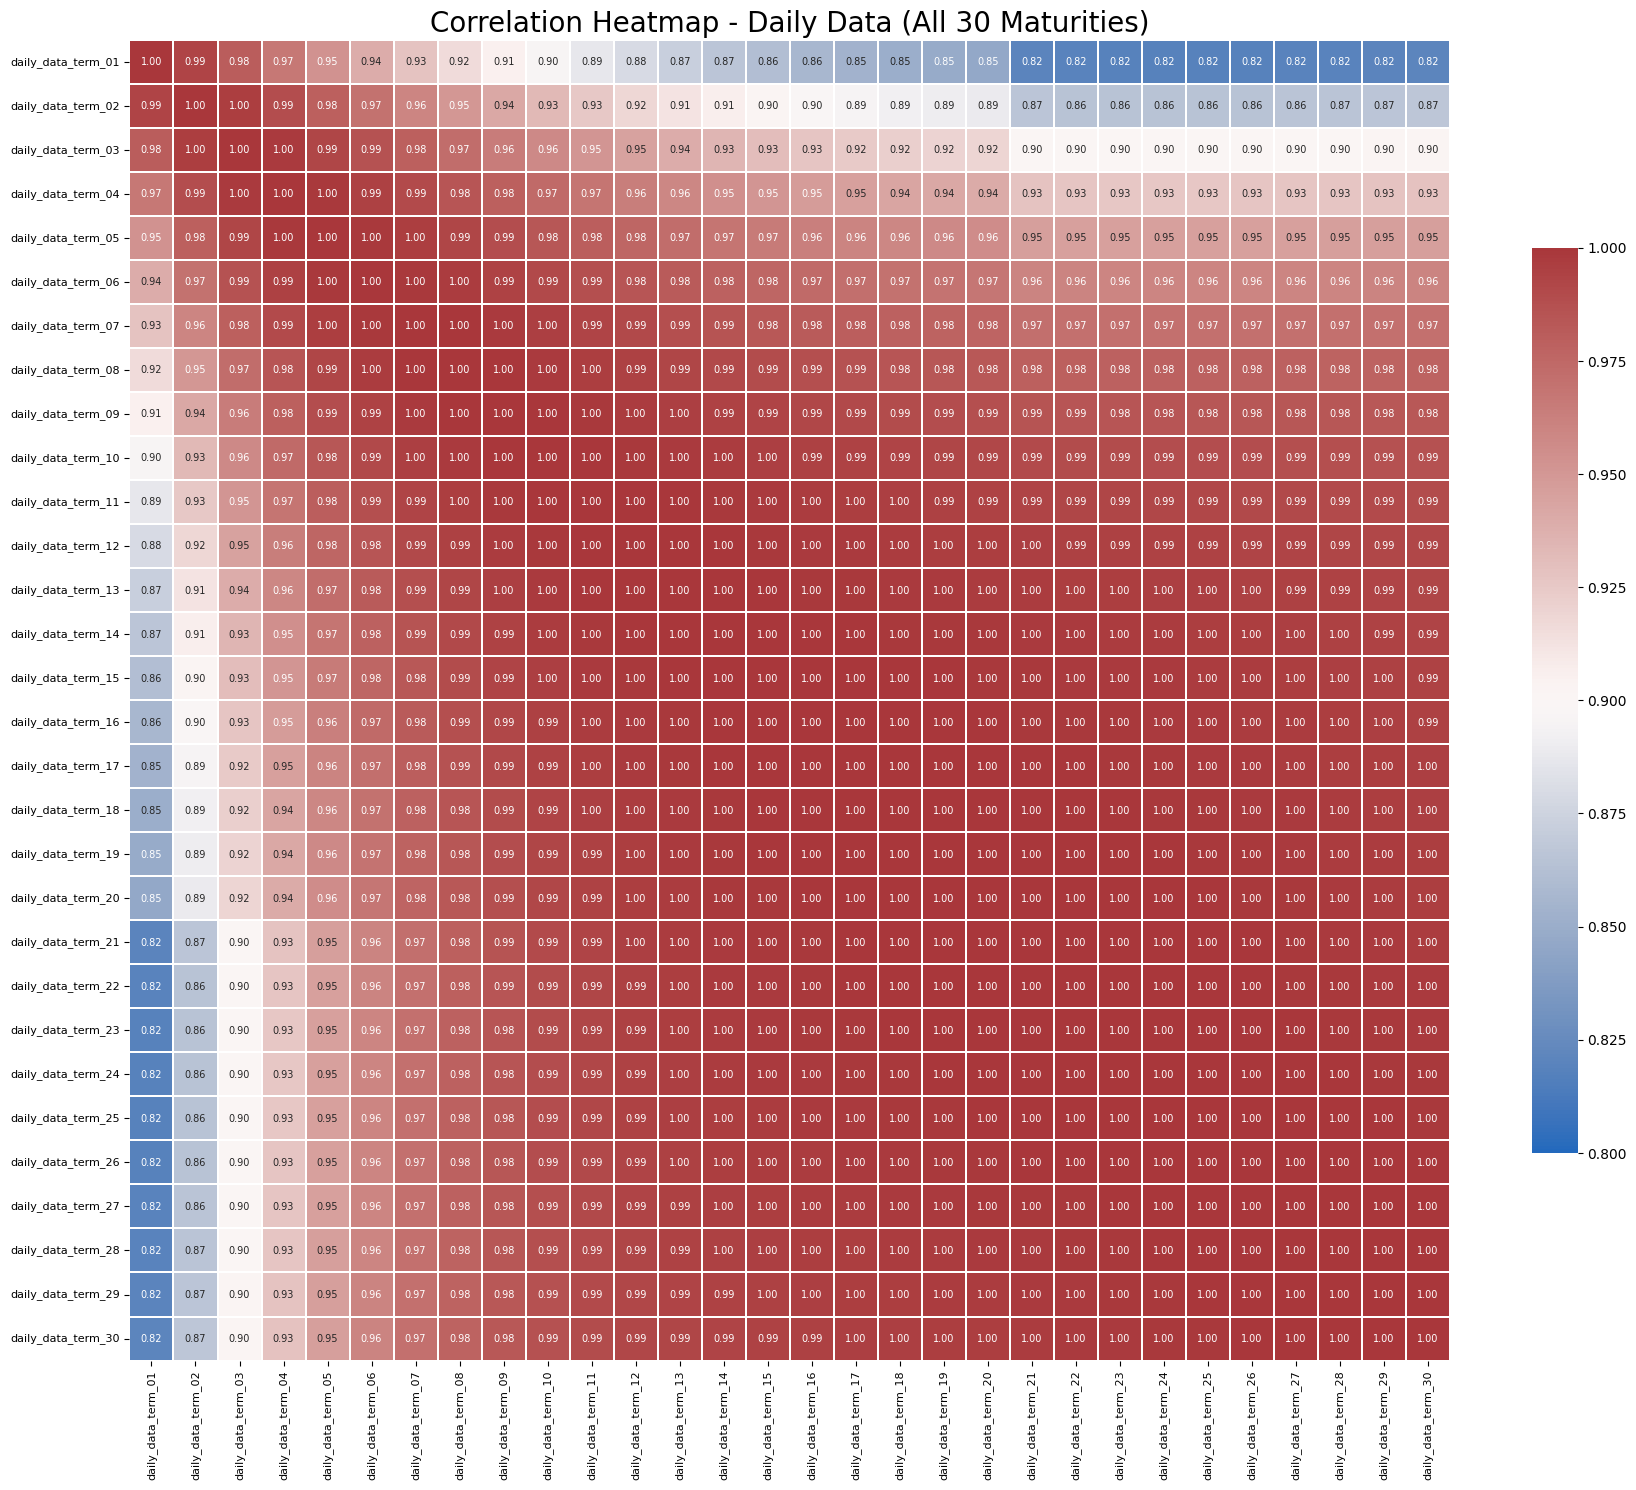

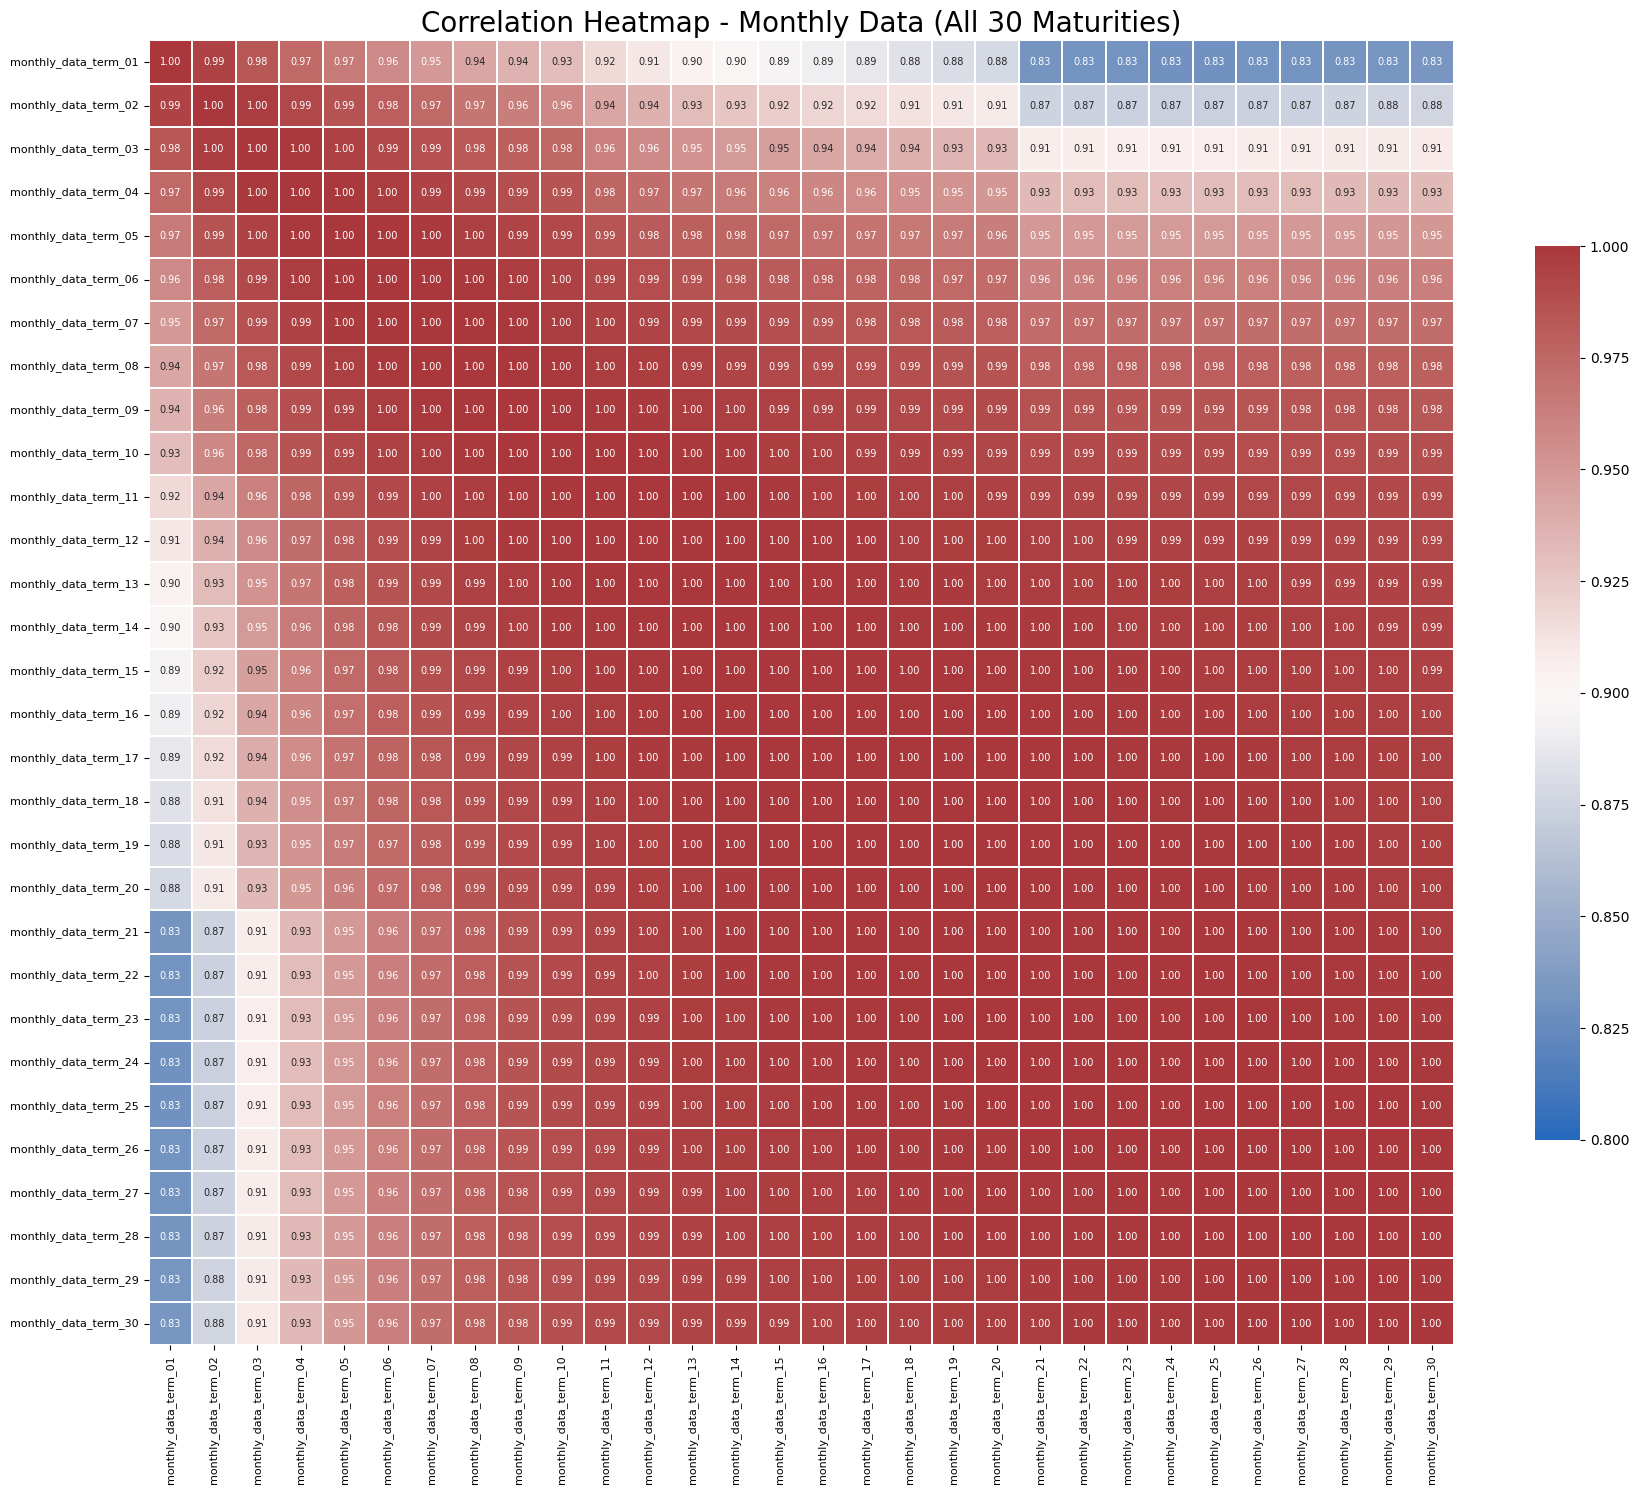

In [97]:
def plot_correlation_heatmap_annotated(df, title):
    term_cols = sorted([col for col in df.columns if 'data_term_' in col])
    corr = df[term_cols].corr()

    plt.figure(figsize=(18,16))
    sns.heatmap(
        corr,
        cmap='vlag',
        center=0.9,
        vmin=0.8,
        vmax=1.0,
        square=True,
        annot=True,
        fmt=".2f",
        annot_kws={"size":7},
        linewidths=0.3,
        cbar_kws={"shrink": 0.6}
    )
    plt.title(title, fontsize=20)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap_annotated(daily_df, 'Correlation Heatmap - Daily Data (All 30 Maturities)')
plot_correlation_heatmap_annotated(monthly_df, 'Correlation Heatmap - Monthly Data (All 30 Maturities)')

In [98]:
#STATIONARITY TEST


def adf_test(df, term=None):
    if term is None:
        term = sorted([col for col in df.columns if col.startswith('daily_data_term_') or col.startswith('monthly_data_term_')])[0]
    series = df[term].dropna()
    result = adfuller(series)
    print(f"ADF test for {term}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, val in result[4].items():
        print(f"   {key}: {val:.4f}")
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print()

adf_test(daily_df)
adf_test(monthly_df)

ADF test for daily_data_term_01:
ADF Statistic: -1.5275
p-value: 0.5199
Critical Values:
   1%: -3.4313
   5%: -2.8620
   10%: -2.5670
Non-stationary

ADF test for monthly_data_term_01:
ADF Statistic: -1.7798
p-value: 0.3906
Critical Values:
   1%: -3.4408
   5%: -2.8662
   10%: -2.5692
Non-stationary



Daily missing % per column:
daily_data_term_30    37.976554
daily_data_term_29    37.976554
daily_data_term_28    37.976554
daily_data_term_27    37.976554
daily_data_term_26    37.976554
daily_data_term_25    37.976554
daily_data_term_24    37.976554
daily_data_term_23    37.976554
daily_data_term_22    37.976554
daily_data_term_21    37.976554
daily_data_term_01    30.568417
daily_data_term_17    30.568417
daily_data_term_20    30.568417
daily_data_term_19    30.568417
daily_data_term_18    30.568417
daily_data_term_16    30.568417
daily_data_term_02    30.568417
daily_data_term_15    30.568417
daily_data_term_14    30.568417
daily_data_term_13    30.568417
daily_data_term_12    30.568417
daily_data_term_11    30.568417
daily_data_term_10    30.568417
daily_data_term_09    30.568417
daily_data_term_08    30.568417
daily_data_term_07    30.568417
daily_data_term_06    30.568417
daily_data_term_05    30.568417
daily_data_term_04    30.568417
daily_data_term_03    30.568417
month       

C:\Users\MK699GC\AppData\Local\Temp\ipykernel_27236\3269798027.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_per_year_daily = daily_df.drop(columns=['years']).groupby('year').apply(lambda x: x.drop(columns=['year']).isna().mean() * 100)
C:\Users\MK699GC\AppData\Local\Temp\ipykernel_27236\3269798027.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_per_year_monthly = monthly_df.drop

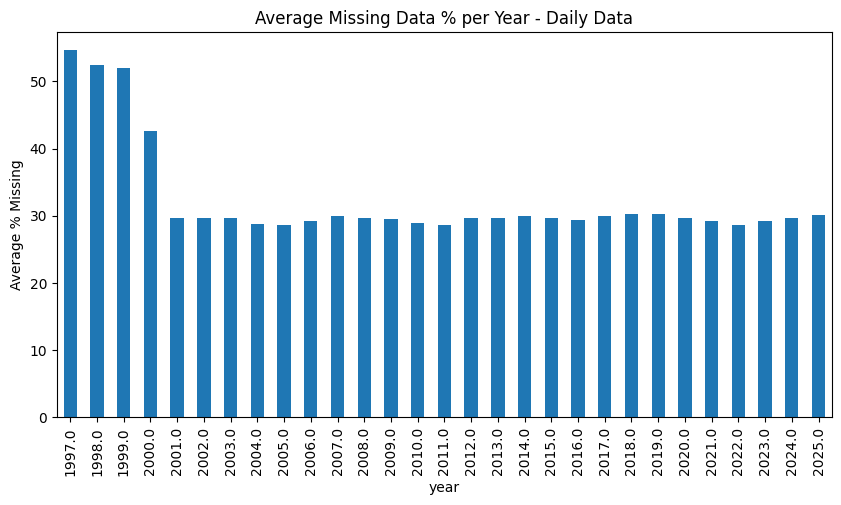

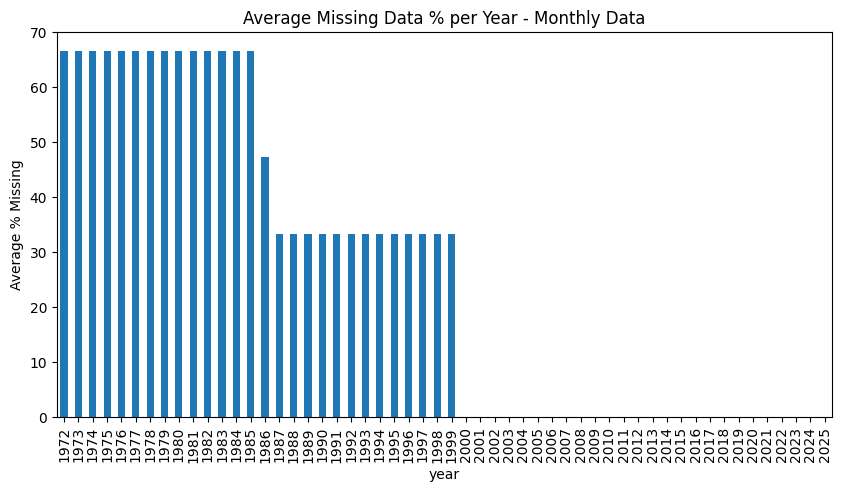

daily_data_term_01: lag-1 autocorrelation in missingness = 0.31
daily_data_term_02: lag-1 autocorrelation in missingness = 0.31
daily_data_term_03: lag-1 autocorrelation in missingness = 0.31
daily_data_term_04: lag-1 autocorrelation in missingness = 0.31
daily_data_term_05: lag-1 autocorrelation in missingness = 0.31
daily_data_term_06: lag-1 autocorrelation in missingness = 0.31
daily_data_term_07: lag-1 autocorrelation in missingness = 0.31
daily_data_term_08: lag-1 autocorrelation in missingness = 0.31
daily_data_term_09: lag-1 autocorrelation in missingness = 0.31
daily_data_term_10: lag-1 autocorrelation in missingness = 0.31
daily_data_term_11: lag-1 autocorrelation in missingness = 0.31
daily_data_term_12: lag-1 autocorrelation in missingness = 0.31
daily_data_term_13: lag-1 autocorrelation in missingness = 0.31
daily_data_term_14: lag-1 autocorrelation in missingness = 0.31
daily_data_term_15: lag-1 autocorrelation in missingness = 0.31
daily_data_term_16: lag-1 autocorrelatio

In [ ]:
#MISSING DATA ANALYSES

# Voeg 'year' toe op basis van 'years'
daily_df['year'] = daily_df['years'].dt.year
monthly_df['year'] = monthly_df['years'].dt.year

# Bereken missing percentages per kolom, excl. 'years' en 'year'
missing_pct_daily = daily_df.drop(columns=['years', 'year']).isna().mean() * 100
missing_pct_monthly = monthly_df.drop(columns=['years', 'year']).isna().mean() * 100

print("Daily missing % per column:")
print(missing_pct_daily.sort_values(ascending=False, na_position='last'))

print("\nMonthly missing % per column:")
print(missing_pct_monthly.sort_values(ascending=False, na_position='last'))

# Bereken missing % per jaar over alle looptijden
missing_per_year_daily = daily_df.drop(columns=['years']).groupby('year').apply(lambda x: x.drop(columns=['year']).isna().mean() * 100)
missing_per_year_monthly = monthly_df.drop(columns=['years']).groupby('year').apply(lambda x: x.drop(columns=['year']).isna().mean() * 100)

print("\nMissing % per year - Daily:")
print(missing_per_year_daily)

print("\nMissing % per year - Monthly:")
print(missing_per_year_monthly)

# Gemiddelde % missing over alle looptijden per jaar
avg_missing_per_year_daily = missing_per_year_daily.mean(axis=1)
avg_missing_per_year_monthly = missing_per_year_monthly.mean(axis=1)

print("\nAverage missing % per year - Daily:")
print(avg_missing_per_year_daily)

print("\nAverage missing % per year - Monthly:")
print(avg_missing_per_year_monthly)

# Plot
avg_missing_per_year_daily.plot(kind='bar', figsize=(10,5))
plt.ylabel('Average % Missing')
plt.title('Average Missing Data % per Year - Daily Data')
plt.show()

avg_missing_per_year_monthly.plot(kind='bar', figsize=(10,5))
plt.ylabel('Average % Missing')
plt.title('Average Missing Data % per Year - Monthly Data')
plt.show()

#CHECK IF THERE IS AUTOCORRELATION IN MISSING DATA
for col in daily_df.columns:
    if col.startswith('daily_data_term_'):
        missing_series = daily_df[col].isna().astype(int)
        autocorr = missing_series.autocorr(lag=1)
        print(f"{col}: lag-1 autocorrelation in missingness = {autocorr:.2f}")






In [ ]:
#CHECK IF THERE ARE INTEREST RATES ABOVE 15% or BELWO -5%
def detect_unreasonable_value_pct(df, min_val=-5, max_val=15):
    df_values = df.drop(columns=['years', 'year'], errors='ignore')
    total_counts = df_values.notna().sum()  # alleen niet-NaN waarden tellen
    mask = (df_values < min_val) | (df_values > max_val)
    bad_counts = mask.sum()
    bad_pct = (bad_counts / total_counts) * 100
    return bad_pct[bad_pct > 0].sort_values(ascending=False)

print("Unreasonable value % (Daily):")
print(detect_unreasonable_value_pct(daily_df))

print("\nUnreasonable value % (Monthly):")
print(detect_unreasonable_value_pct(monthly_df))

#CHECK IF THERE OUTLIERS BASED ON Z-SCORES
def detect_outliers(df, threshold=3):
    df_values = df.drop(columns=['years', 'year'], errors='ignore')
    z_scores = (df_values - df_values.mean()) / df_values.std()
    outlier_mask = (z_scores.abs() > threshold)
    outlier_counts = outlier_mask.sum().sort_values(ascending=False)
    return outlier_counts[outlier_counts > 0]


print("Outliers (Daily):")
print(detect_outliers(daily_df))

print("\nOutliers (Monthly):")
print(detect_outliers(monthly_df))




Unreasonable value % (Daily):
Series([], dtype: float64)

Unreasonable value % (Monthly):
Series([], dtype: float64)
Outliers (Daily):
Series([], dtype: int64)

Outliers (Monthly):
Series([], dtype: int64)
